In [1]:
import os
import numpy as np
import mxnet as mx
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv
from model.simple_stack import SimpleStack
from PIL import Image

In [2]:
agent_view = 5
map_size = 20
rounds = 5
ctx = mx.gpu()
env = SimpleEnv(display=False, agent_view=agent_view, map_size=map_size)
model = SimpleStack()
model.load_parameters("./model_save/model_test.params.best", ctx)
save = "./data_save/"
print_action=False

In [3]:
avg_extrinsic_reward = []
avg_reward_rate = []

In [4]:
for epoch in range(rounds):
    env.reset_env()
    done = 0
    step = 0
    while not done:
        step += 1
        data = create_input([translate_state(env.map.state())])
        data = [nd.array(i, ctx=ctx) for i in data]
        pred = model(data)
        action = int(nd.argmax(pred, axis=1).asnumpy()[0])
        old, new, reward, done = env.step(action)
        if print_action:
            print(pred, reward, env.map.battery)
        if save is not None:
            img = Image.fromarray(env.map.grid.render(10,env.map.agent_pos,env.map.agent_dir), 'RGB')
            pred = [str(x)[0:5] for x in pred.asnumpy().tolist()[0]]
            filename = str(epoch) + "-" + str(step) + "-" + str(reward) + "-" + "_".join(pred) + ".jpg"
            img.save(save + "/" + filename)
    avg_reward_rate.append(env._rewards[-1] / sum([abs(i) for i in env._rewards]))
    avg_extrinsic_reward.append(env.map._extrinsic_reward())

In [23]:
_ = env.map.grid.copy()

In [36]:
x = env.map.gen_obs_grid()[0].grid[15]

In [52]:
np.array(_.grid).reshape(20,)

(400,)

In [ ]:
_.grid = [None if i is not None and i.type == "box" else i for i in _.grid]

In [16]:
data = create_input([translate_state(env.map.state())])
data = [nd.array(i, ctx=ctx) for i in data]

In [19]:
_view, _map, _battery = data
_battery = nd.expand_dims(_battery, axis=1)
_view = model.view(_view)
_map = nd.transpose(_map, [1, 0, 2, 3])
_map, _memory = _map
_map = nd.one_hot(_map, 7).transpose([0, 3, 1, 2])
# _map = nd.expand_dims(_map, axis=1)
_memory = nd.expand_dims(_memory, axis=1)

In [21]:
_map = model.map(_map)
_memory = model.memory(_memory)

In [22]:
_map


[[-1.         -1.         -1.          1.         -1.          1.
   1.          1.         -1.          1.         -1.         -1.
   1.          1.          1.         -1.          1.         -1.
   1.         -1.          1.          1.          1.         -1.
  -1.          1.         -1.          1.         -1.          1.
   1.          1.         -1.          1.         -0.99996895  1.
   1.          1.         -1.         -1.          1.         -1.
   1.         -1.          1.          1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
   1.         -1.         -1.         -1.          1.          1.
  -1.          1.          1.         -0.9999793  -1.         -1.
  -1.          1.          1.          1.          1.          1.
   1.          1.         -1.         -1.          1.         -1.
   1.         -1.         -1.         -1.          1.          1.
   1.          1.         -1.         -0.6785034  -1.         -1.
   1.    

In [5]:
np.mean(avg_extrinsic_reward), np.mean(avg_reward_rate)

(0.0125, -0.020255866793326388)

In [6]:
import seaborn
import tqdm

100%|██████████| 4/4 [00:00<00:00, 8621.39it/s]


<AxesSubplot:>

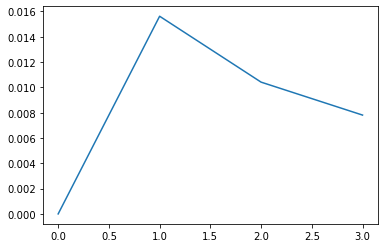

In [7]:
y = []
for i in tqdm.tqdm(range(1, len(env.detect_rate))):
    y.append(np.mean(env.detect_rate[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

100%|██████████| 4/4 [00:00<00:00, 8599.29it/s]


<AxesSubplot:>

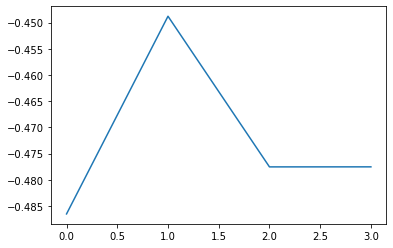

In [8]:
y = []
for i in tqdm.tqdm(range(1, len(env.rewards))):
    y.append(np.mean(env.rewards[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

In [9]:
env._rewards

[-0.05,
 -0.05,
 -0.05,
 -0.04,
 -0.03,
 -0.02,
 -0.02,
 -0.02,
 -0.03,
 -0.04,
 -0.05,
 -0.05,
 -0.060000000000000005,
 -0.07,
 -0.08,
 -0.09,
 -0.1,
 -0.11,
 -0.12000000000000001,
 -0.13,
 -0.14,
 -0.15000000000000002,
 -0.16,
 -0.16999999999999998,
 -0.18,
 -0.19,
 -0.2,
 -0.21000000000000002,
 -0.22000000000000003,
 -0.22999999999999998,
 -0.24,
 -0.25,
 -0.26,
 -0.27,
 -0.28,
 -0.29,
 -0.3,
 -0.31,
 -0.32,
 -0.33,
 -0.33999999999999997,
 -0.35,
 -0.36,
 -0.37,
 -0.38,
 -0.39,
 -0.39999999999999997,
 -0.41,
 -0.42,
 -0.43,
 -0.44,
 -0.45,
 -0.45999999999999996,
 -0.47,
 -0.48,
 -0.49,
 -0.5,
 -0.51,
 -0.52,
 -0.53,
 -0.54,
 -0.55,
 -0.56,
 -0.5700000000000001,
 -0.5800000000000001,
 -0.5900000000000001,
 -0.6000000000000001,
 -0.6100000000000001,
 -0.62,
 -0.63,
 -0.64,
 -0.65,
 -0.66,
 -0.67,
 -0.68,
 -0.6900000000000001,
 -0.7000000000000001,
 -0.7100000000000001,
 -0.7200000000000001,
 -0.7300000000000001,
 -0.74,
 -0.75,
 -0.76,
 -0.77,
 -0.78,
 -0.79,
 -0.8,
 -0.81,
 -0.820000